In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import numpy as onp
from reusable.util import (
    load_args,
    load_training_history,
    load_scores,
    gen_file_name,
    get_decoder_params,
    load_training_state,
)
import matplotlib.pyplot as plt
from plotting.plots import plot_training, plot_draws_hpdi
import jax.random as random
from reusable.vae import VAE, vae_sample
from reusable.train_nn import SimpleTrainState
import optax
from numpyro.infer import Predictive
from reusable.gp import BuildGP
import pandas
from plotting.paper import align_left_backfill, align_right_backfill, calc_plot_dimensions, clear_unused_axs, align_right_backfill_with_gp, pretty_loss_fn_name


# Experiments for different loss functions

In [126]:
def plot_training_histories(code, exp_name, args_count, num_cols=None, num_rows=None, backfill=None):
    args = load_args(str(code), args_count, exp_name)

    twoD, num_rows, num_cols = calc_plot_dimensions(args, num_cols, num_rows, False, False)

    match backfill:
        case None:
            mapping = lambda i: i
        case "align_left":
            mapping = align_left_backfill(len(args["loss_fns"]), num_rows, num_cols)
        case "align_right":
            mapping = align_right_backfill(len(args["loss_fns"]), num_rows, num_cols)

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 6, num_rows * 5))

    clear_unused_axs(axs, mapping, twoD, len(args["loss_fn_names"]))

    for i, loss_fn in enumerate(args["loss_fn_names"]):

        hist = load_training_history(code, gen_file_name(code, args, args["experiment"] + loss_fn))
        plot_training(
            hist["test_loss"],
            hist["train_loss"],
            pretty_loss_fn_name(loss_fn),
            ax=axs[onp.unravel_index(mapping(i), (num_rows, num_cols)) if twoD else i],
        )

    fig.tight_layout()
    
    fig.savefig(f"./gen_plots/{code}/{code}_{exp_name}_{args_count}_training.pdf")


In [127]:
def plot_trained_draws(code, exp_name, args_count, num_cols=None, num_rows=None, backfill=None, separate_gp=False, include_standard_vae=False):
    rng_key = random.PRNGKey(3)
    rng_key, rng_key_gp = random.split(rng_key, 2)

    args = load_args(str(code), str(args_count), exp_name)

    if include_standard_vae:
        args["loss_fn_names"] = ["RCL+KLD"] + args["loss_fn_names"]
        

    twoD, num_rows, num_cols = calc_plot_dimensions(args, num_cols, num_rows, True, separate_gp, include_standard_vae)
    print(len(args["loss_fn_names"]), twoD, num_rows, num_cols)

    match backfill:
        case None:
            if separate_gp:
                mapping = lambda i: 0 if i == 0 else i - 1 + num_cols
            else:
                mapping = lambda i: i
        case "align_left":
            mapping = align_left_backfill(len(args["loss_fn_names"]) + 1, num_rows, num_cols)
        case "align_right":
            mapping = align_right_backfill_with_gp(len(args["loss_fn_names"]) + 1, num_rows, num_cols)

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 6, num_rows * 5))

    clear_unused_axs(axs, mapping, twoD, len(args["loss_fn_names"]) + 1)

    gp = BuildGP(
        args["gp_kernel"],
        noise=False,
        length_prior_choice=args["length_prior_choice"],
        prior_args=args["length_prior_arguments"],
    )

    plot_gp_predictive = Predictive(gp, num_samples=5000)

    gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5)["y"]
    plot_draws_hpdi(
        gp_draws,
        args["x"],
        f"GP draws",
        "$y=f_{GP}(x)$",
        "GP",
        ax=axs[onp.unravel_index(mapping(0), (num_rows, num_cols)) if twoD else 0],
    )

    for i, loss_fn in enumerate(args["loss_fn_names"]):
        rng_key, rng_key_init, rng_key_predict = random.split(rng_key, 3)

        module = VAE(
            hidden_dim1=args["hidden_dim1"],
            hidden_dim2=args["hidden_dim2"],
            latent_dim=args["latent_dim"],
            out_dim=args["n"],
            conditional=False,
            leaky=False
        )
        params = module.init(rng_key, jnp.ones((args["n"],)))["params"]
        tx = optax.adam(args["learning_rate"])
        state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init)

        if include_standard_vae and loss_fn == "RCL+KLD":
            "doing!!!!"
            decoder_params = get_decoder_params(
                load_training_state("16", gen_file_name("16", args, "exp1" + loss_fn), state)
            
            )
        else:
            decoder_params = get_decoder_params(
                load_training_state(code, gen_file_name(code, args, args["experiment"] + loss_fn), state)
                
            )

        plot_vae_predictive = Predictive(vae_sample, num_samples=5000)
        vae_draws = plot_vae_predictive(
            rng_key_predict,
            hidden_dim1=args["hidden_dim1"],
            hidden_dim2=args["hidden_dim2"],
            latent_dim=args["latent_dim"],
            out_dim=args["n"],
            decoder_params=decoder_params,
        )["f"]
        plot_draws_hpdi(
            vae_draws,
            args["x"],
            pretty_loss_fn_name(loss_fn),
            "$y=f_{VAE}(x)$",
            "PriorVAE",
            ax=axs[onp.unravel_index(mapping(i + 1), (num_rows, num_cols)) if twoD else i + 1],
        )

    fig.tight_layout()

    fig.savefig(f"./gen_plots/{code}/{code}_{exp_name}_{args_count}_draws.pdf")


In [159]:
def merge_dicts(a: dict, b: dict):
    for key, val in b.items():
        if len(val) > 0 and isinstance(val[0], str):
            if key not in a:
                a[key] = [val]
            else:
                a[key] = a[key] + [val]
        else:
            if key not in a:
                a[key] = jnp.array(val)[None]
            else:
                a[key] = jnp.concatenate((a[key], jnp.array(val)[None]), axis=0)


def get_loss_scores(code: int, exp_name, args_count: int):
    """Given the raw data (which is v. oddly formatted), return a dictionary of lists:
    - loss_fns
    - frobenius: items: array of length num_orders_calced
    - vae_moments: 2d array: (num_orders, n)
    - mmd: items: array of values for each kernel choice
    - mmd_kernels: list of string names
    """
    args = load_args(str(code), str(args_count), exp_name)

    scores = {"loss_fns": []}
    for i, loss_fn in enumerate(args["loss_fn_names"]):
        scores["loss_fns"].append(loss_fn)
        s = load_scores(
            args["expcode"],
            gen_file_name(code, args, args["experiment"] + loss_fn),
        )
        
        s["mmd_kernels"] = [x[0] for x in s["mmd"]]
        s["mmd"] = [x[1] for x in s["mmd"]]
        s["avg_vae_moments"] = [jnp.mean(x) for x in s["vae_moments"]]
        print(s["avg_vae_moments"])
        merge_dicts(scores, s)

    return scores


def get_gp_moments():
    args = load_args("16", str(1), "exp1")
    scores = load_scores("16", gen_file_name("16", args, args["experiment"] + args["loss_fn_names"][0]),)

    return [jnp.mean(x) for x in scores["gp_moments"]]


def show_loss_scores(code, exp_name, args_count):

    scores = get_loss_scores(code, exp_name, args_count)

    scores["avg_vae_moments"] = jnp.abs(jnp.array(scores["avg_vae_moments"]) - jnp.array(get_gp_moments()))

    score_types = ["frobenius", "mmd", "avg_vae_moments"]  # 
    std_range = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    col_type = ["Moment", "MMD kernel", "Moments difference"]
    pretty_labels = [std_range, [pretty_loss_fn_name(x) for x in scores["mmd_kernels"][0]], std_range]
    plain_labels = [std_range, scores["mmd_kernels"][0], std_range]

    for score_type, plain, col_type, pretty in zip(score_types, plain_labels, col_type, pretty_labels):
        df = pandas.DataFrame(
            scores[score_type],
            columns=pandas.Index(pretty, name=col_type),
            index=pandas.Index([pretty_loss_fn_name(x) for x in scores["loss_fns"]], name="Loss functions"),
        )
        
        ranks = jnp.array(scores[score_type]).argsort(axis=0).argsort(axis=0)
        log = jnp.log(jnp.array(scores[score_type]))
        # 
        log_per_col = log / jnp.max(log, axis=0)
        print("log")
        print(log)
        print("log_per")
        print(log_per_col)
        cmap = plt.get_cmap("Blues_r")
        cmap.set_bad(color='red')

        s = df.style
        s.background_gradient(axis=None, cmap=cmap, gmap=ranks)

        s.format(" ")
        if col_type == "MMD kernel":
            s.format_index("\\rot{{{}}}", axis=1)

        with open(f"./gen_plots/{code}/tables/{code}_{exp_name}_{args_count}_{score_type}_rank_table.tex", "w") as f:
            s.to_latex(f, convert_css=True)

        df = pandas.DataFrame(
            scores[score_type],
            columns=pandas.Index(pretty, name=col_type),
            index=pandas.Index([pretty_loss_fn_name(x) for x in scores["loss_fns"]], name="Loss functions"),
        )
        
        
        s = df.style
        
        s.background_gradient(axis=None, cmap=cmap)

        s.format(" ")
        if col_type == "MMD kernel":
            s.format_index("\\rot{{{}}}", axis=1)

        with open(f"./gen_plots/{code}/tables/{code}_{exp_name}_{args_count}_{score_type}_vals_table.tex", "w") as f:
            s.to_latex(f, convert_css=True)
      
        
        # df = pandas.DataFrame(
        #     scores[score_type], columns=pandas.Index(plain, name=col_type), index=pandas.Index(scores["loss_fns"], name="Loss functions")
        # )


        # s = df.style# .highlight_min(axis=0, props="font-weight:bold;")
        # print(scores[score_type].shape)

        # s.format("{:.1e}")


        # s.background_gradient(axis=None, cmap="Blues_r", gmap=ranks)
        
        # display(s)

        df = pandas.DataFrame(
            scores[score_type], columns=pandas.Index(plain, name=col_type), index=pandas.Index(scores["loss_fns"], name="Loss functions")
        )


        s = df.style# .highlight_min(axis=0, props="font-weight:bold;")
        print(scores[score_type].shape)

        s.format("{:.1e}", na_rep="NaN")


        s.background_gradient(axis=None, cmap=cmap, gmap=log_per_col)
        
        display(s)



    pass

In [160]:
experiment = "exp1"
number = "1" # disambiguate argument files

show_loss_scores(16, experiment, number)

#plot_training_histories(16, experiment, number, num_cols=4, num_rows=3, backfill="align_right")
#plot_trained_draws(16, experiment, number, num_cols=4, num_rows=3, backfill="align_right")

#show_loss_scores_mat(16, experiment, number)

[Array(0.01124816, dtype=float32), Array(0.24121791, dtype=float32), Array(-0.00062419, dtype=float32), Array(0.17890164, dtype=float32), Array(-0.00416365, dtype=float32), Array(0.22087696, dtype=float32), Array(-0.01641927, dtype=float32), Array(0.37564093, dtype=float32), Array(-0.06192831, dtype=float32)]
[Array(-20.272928, dtype=float32), Array(357.41504, dtype=float32), Array(-1533.7212, dtype=float32), Array(839564.9, dtype=float32), Array(17920936., dtype=float32), Array(8.4402227e+09, dtype=float32), Array(8.626596e+11, dtype=float32), Array(1.9808092e+14, dtype=float32), Array(3.2197534e+16, dtype=float32)]
[Array(-0.61961365, dtype=float32), Array(16.11389, dtype=float32), Array(-546.3758, dtype=float32), Array(25521.734, dtype=float32), Array(-1375699.1, dtype=float32), Array(82093144., dtype=float32), Array(-5.259374e+09, dtype=float32), Array(3.5440594e+11, dtype=float32), Array(-2.4773009e+13, dtype=float32)]
[Array(0.09925959, dtype=float32), Array(2.2459817, dtype=floa

log
[[ -5.0048203   -2.1301057   -2.1098747   -2.7470121   -3.0367239
   -2.1627817   -2.5687141   -1.9007741   -2.3119204   -1.8792892
   -2.276499  ]
 [ -8.479303    -3.4662564   -1.2399917   -0.87298477  -0.5935647
   -1.4977773   -0.72875005  -2.3427272   -0.99886817  -2.460603
   -1.0382653 ]
 [-10.558659    -8.4480505   -7.728631    -7.1367445   -6.893943
   -7.6354423   -6.90968     -8.389439    -7.332039    -8.419407
   -7.4210057 ]
 [ -9.637161    -7.942688    -7.893981    -8.173478    -8.249534
   -7.943505    -7.8548307   -8.0434065   -7.7809772   -8.051426
   -7.789143  ]
 [ -8.7430725   -7.1652827   -8.520463    -8.223569    -8.911386
   -7.756141    -8.747031    -7.502327    -8.744578    -7.464233
   -8.752883  ]
 [ -6.508761    -2.4923239   -2.2488837   -2.9881568   -3.2147896
   -2.395415    -2.715674    -2.1441858   -2.4390752   -2.1270819
   -2.4010005 ]
 [ -8.018719    -3.3649926   -2.6999643   -3.5856822   -3.7204208
   -3.0055704   -3.1710231   -2.8064291   -2.8598

log
[[-10.849018    -0.26063332  -7.0668426    1.0706304   -2.0657082
    2.7494423    1.1166337    4.731517     4.0766945 ]
 [  3.00984      5.876063     7.335451    13.6406355   16.70148
   22.856274    27.483286    32.919697    38.010666  ]
 [ -0.46069923   2.7148345    6.303304    10.147164    14.134473
   18.223366    22.383278    26.593708    30.840776  ]
 [ -2.430068     0.21042328   2.7982023    5.6678476    8.66308
   11.760776    14.925268    18.13517     21.376297  ]
 [ -3.8191037   -0.83930284  -0.3983876    4.910721     4.0968876
   11.103478    11.677468    17.506372    19.029028  ]
 [ -4.2127366   -0.29754514  -5.9291387    1.0609459   -2.1141245
    2.747345     1.1142764    4.731174     4.076699  ]
 [ -3.608544    -0.4365963   -6.342493     1.001086    -2.121179
    2.7243884    1.1039338    4.722946     4.072385  ]
 [ -4.3229914   -0.44254526  -5.8729553    1.0024133   -2.0926557
    2.7258508    1.1159663    4.723933     4.076379  ]
 [ -5.925404    -0.4472422   -5.10

21 True 5 5


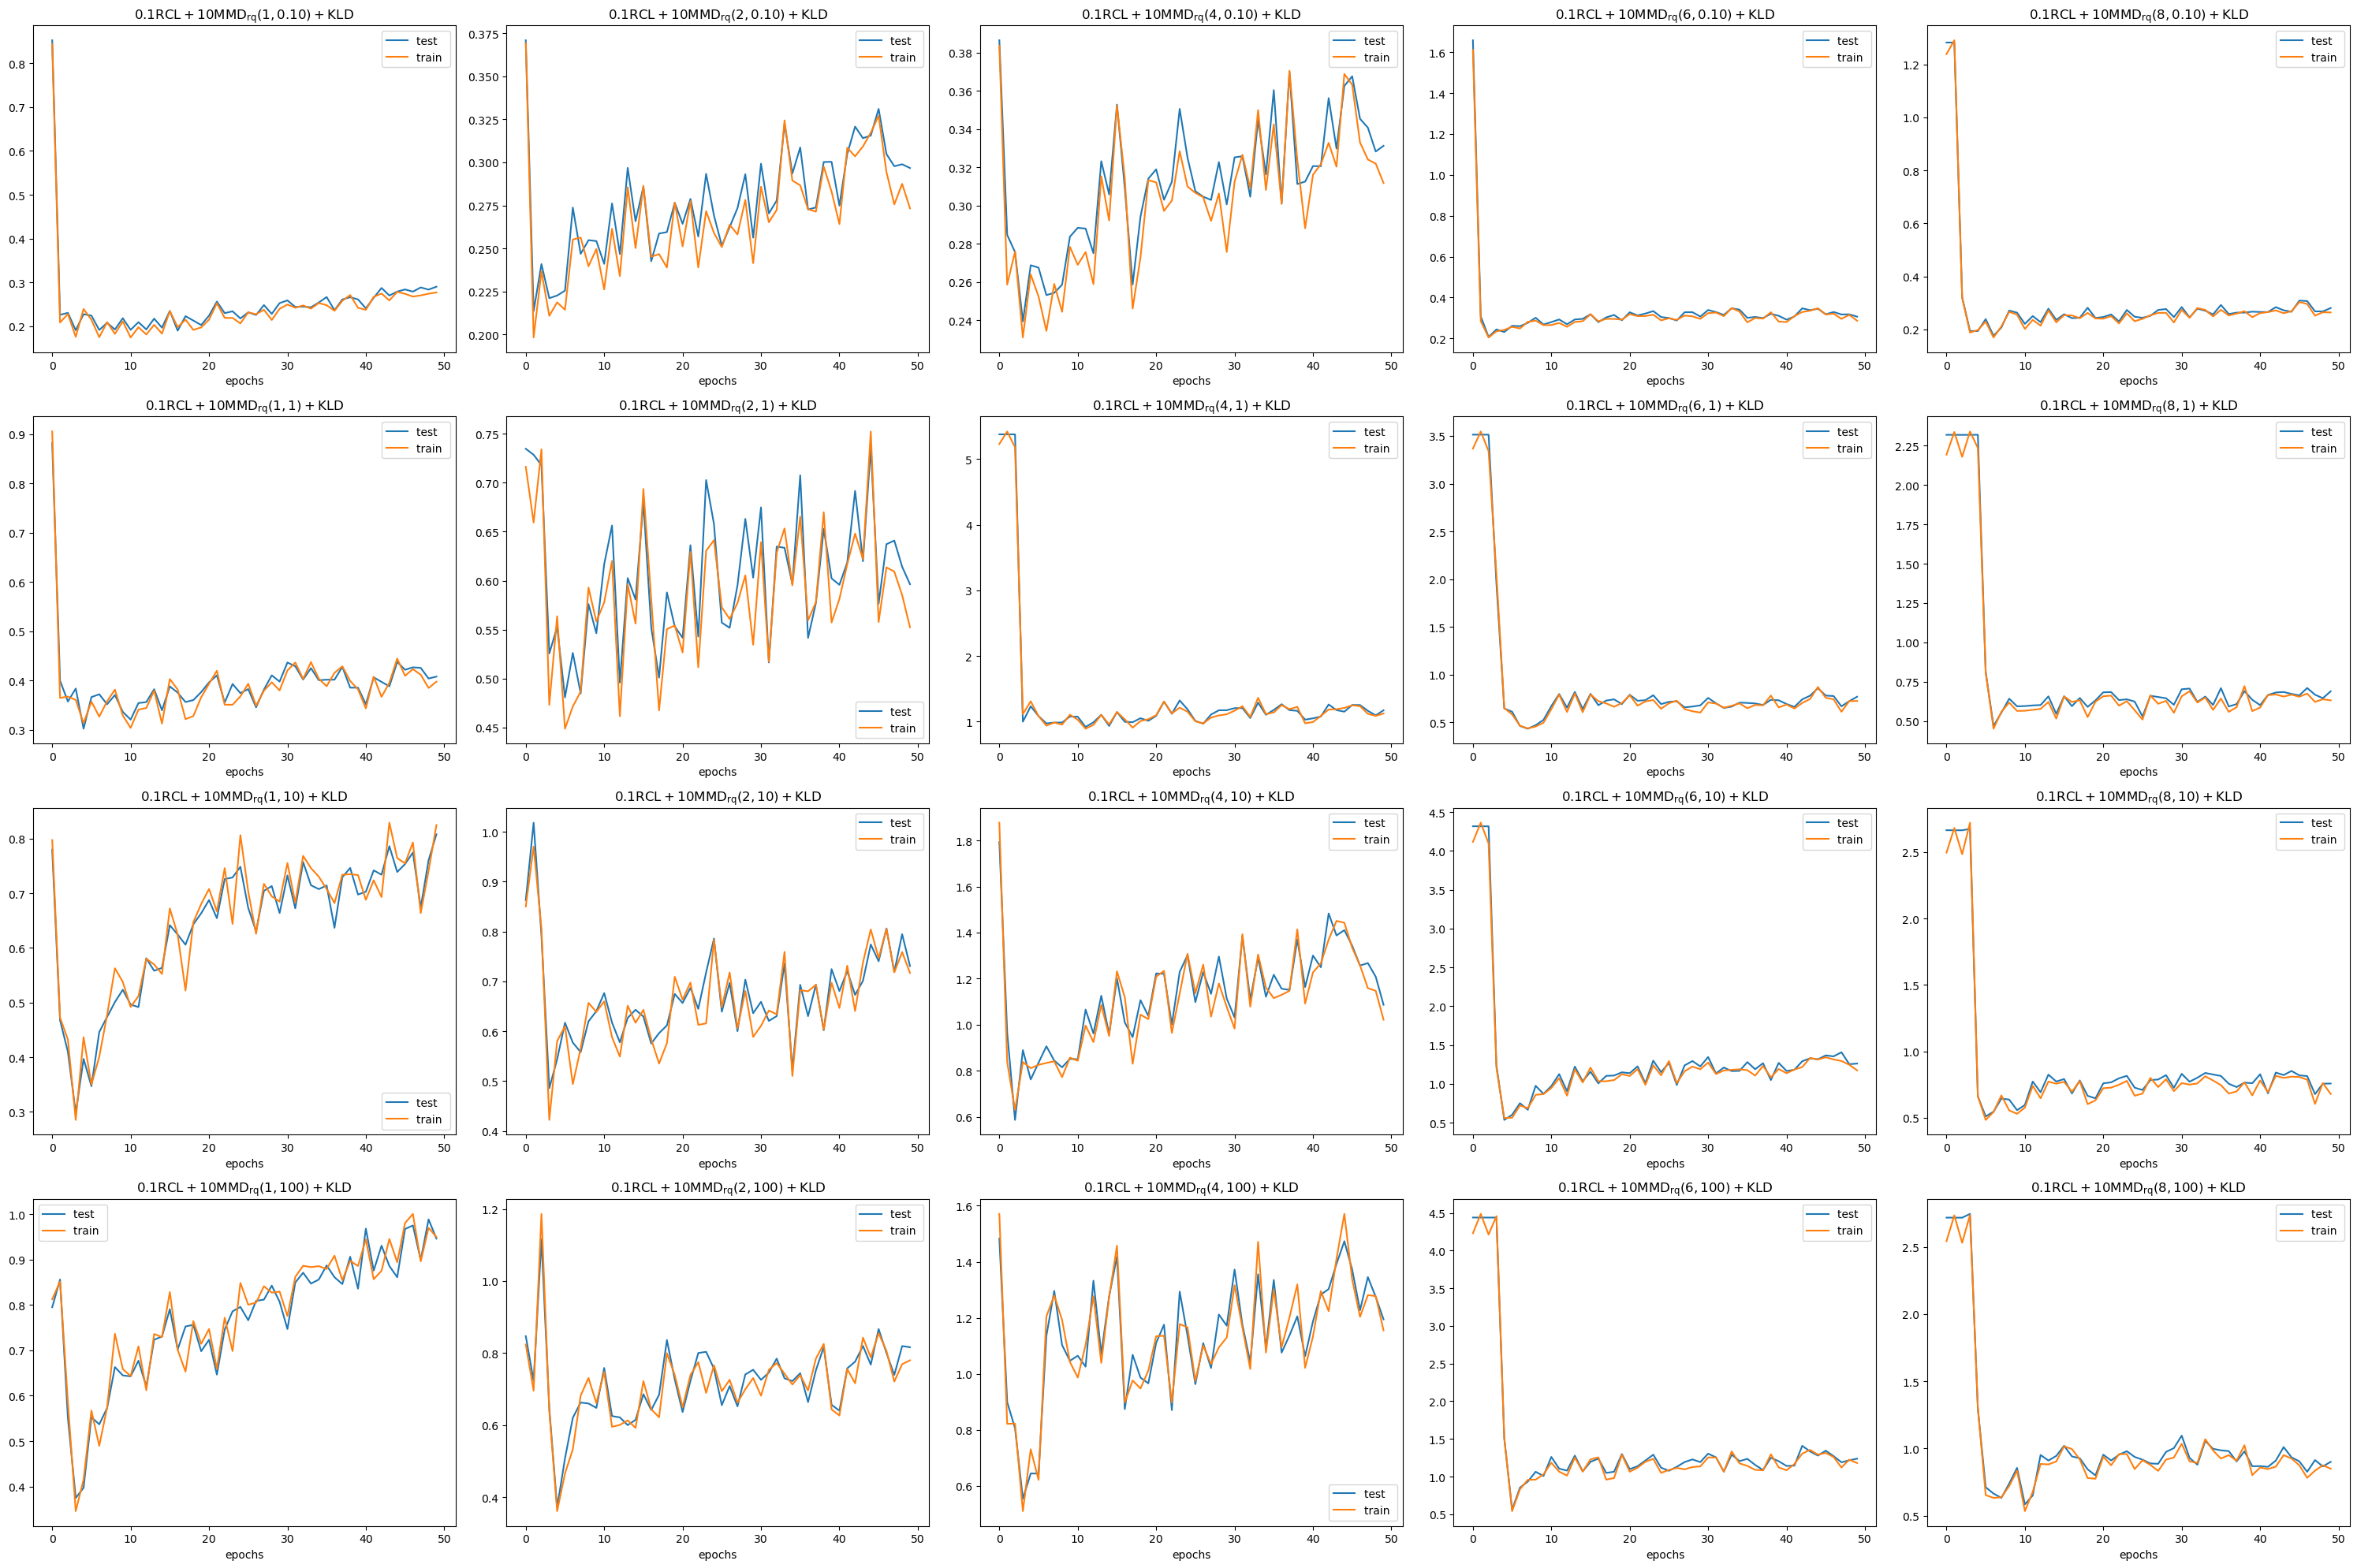

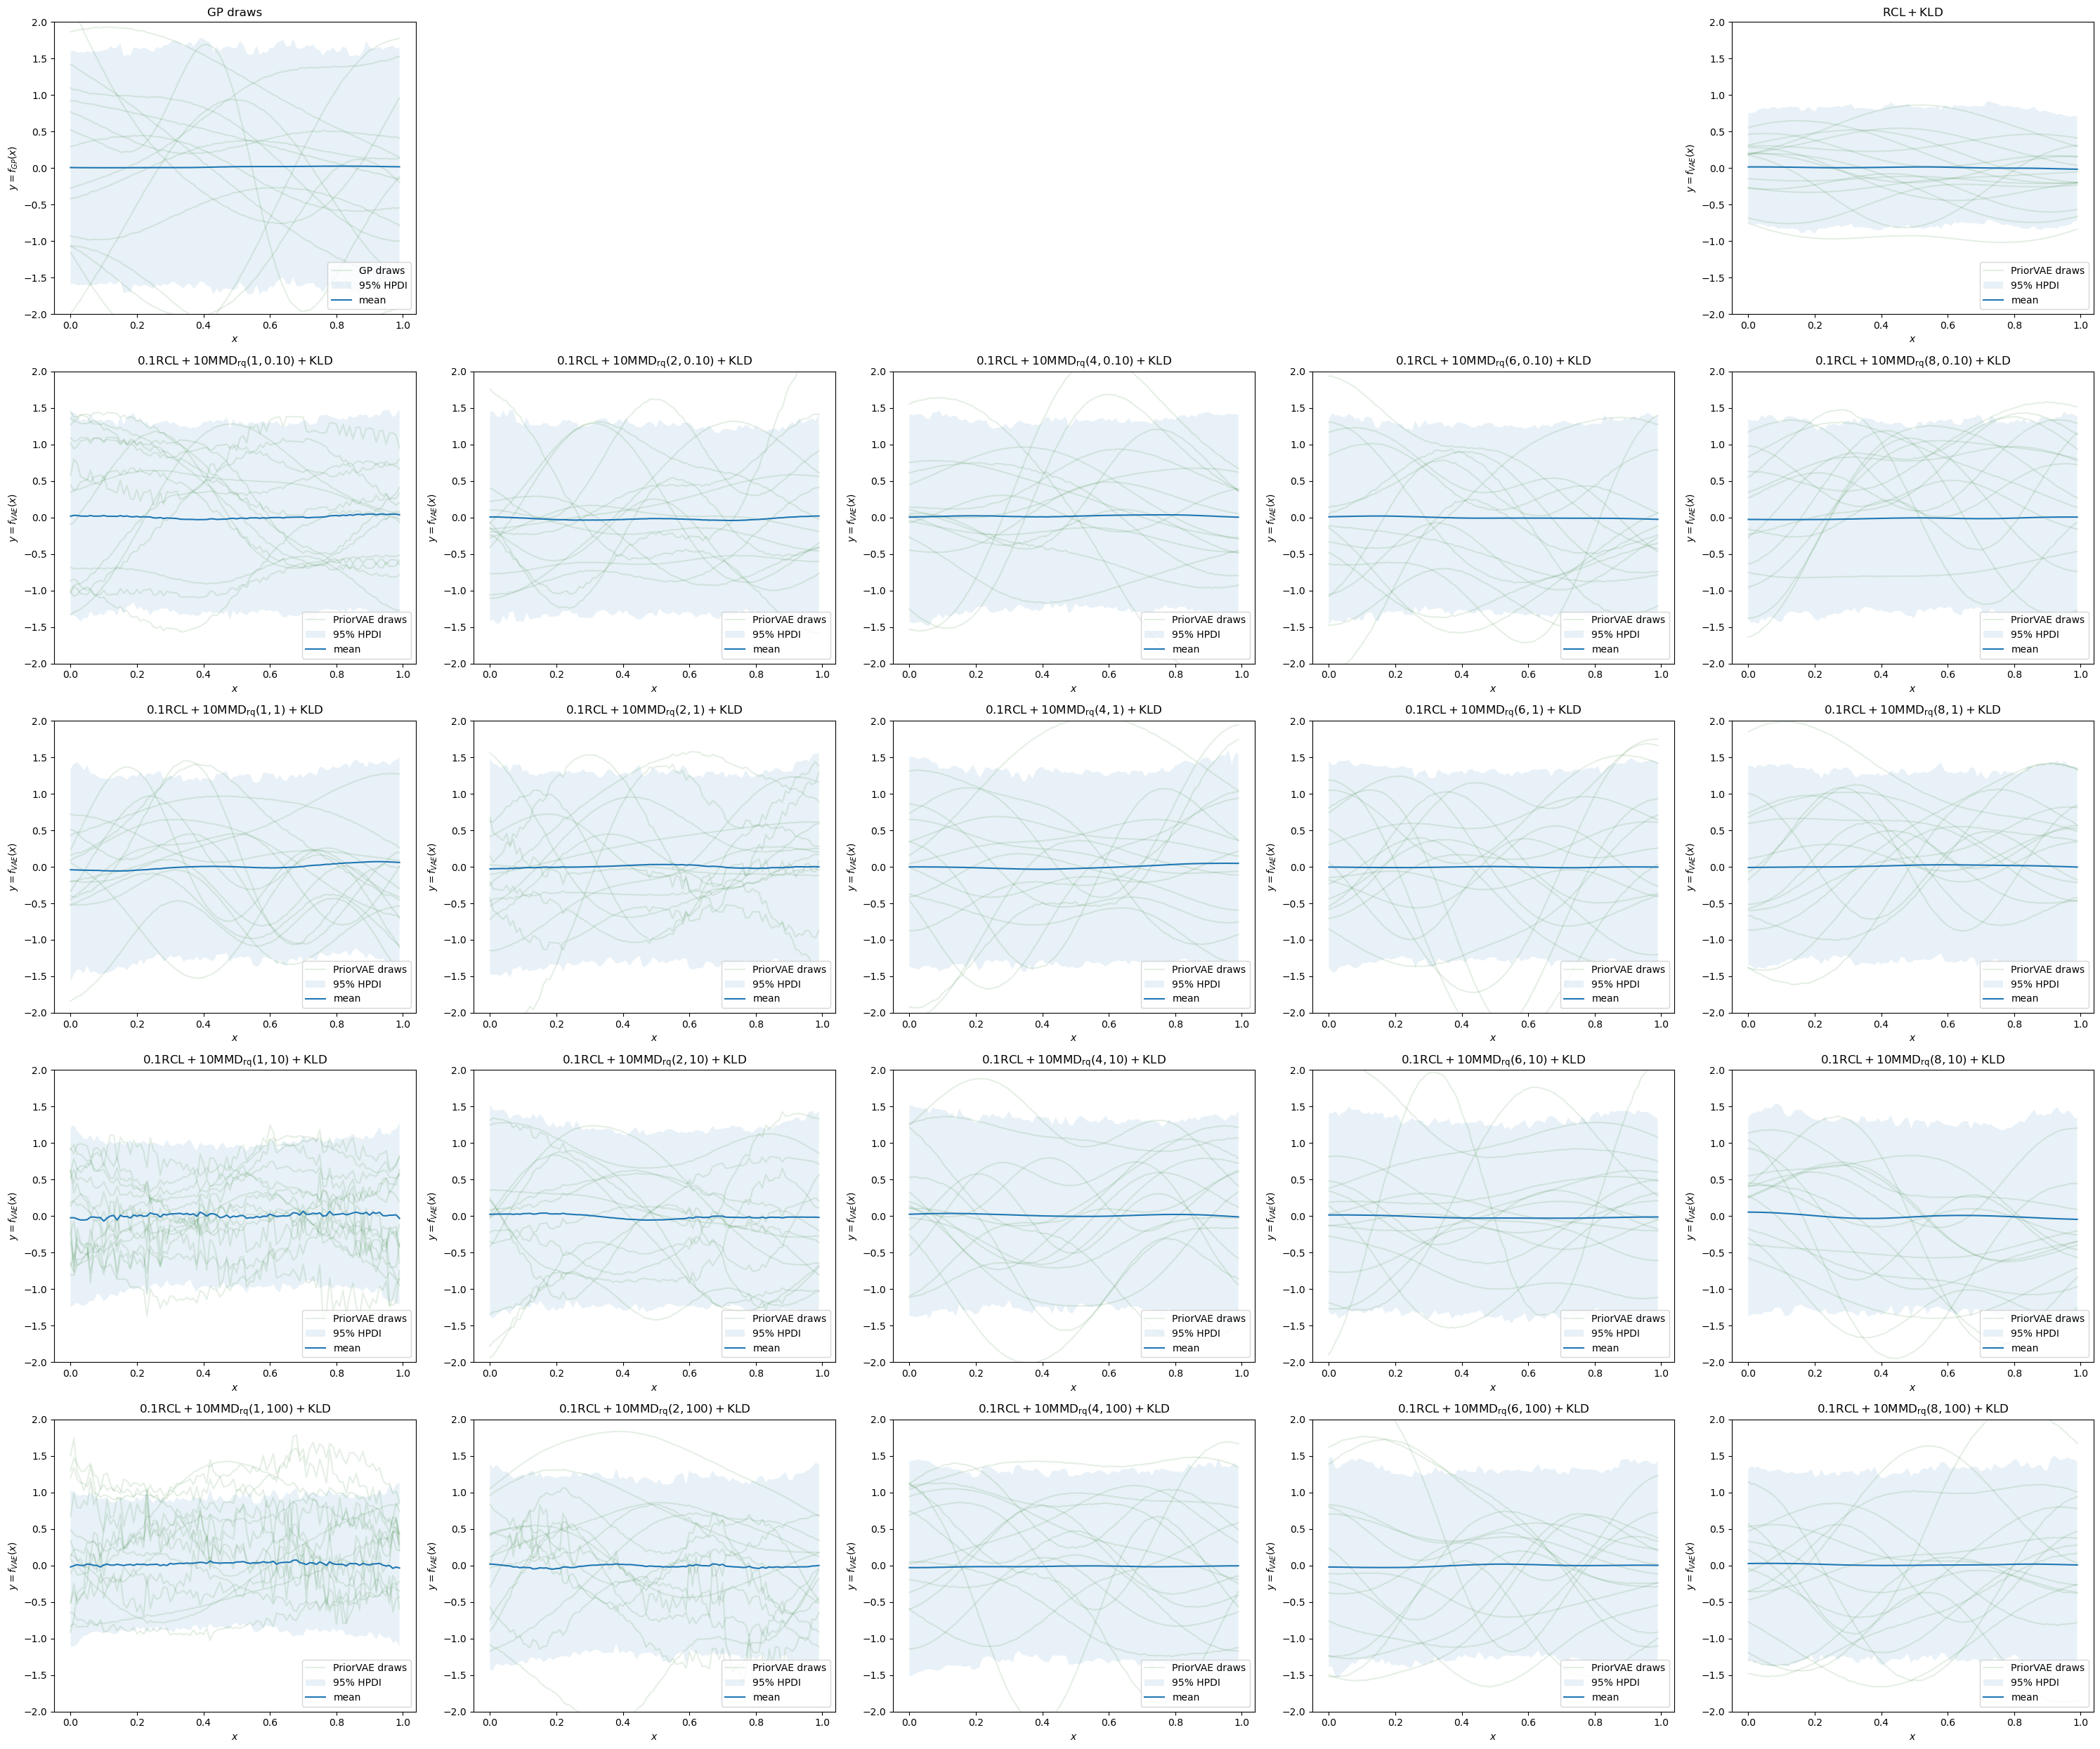

In [135]:
experiment = "exp2"
number = "1" # disambiguate argument files

show_loss_scores(16, experiment, number)
#plot_training_histories(16, experiment, number, backfill="align_right")
#plot_trained_draws(16, experiment, number,  backfill="align_right", include_standard_vae=True)

21 True 6 4


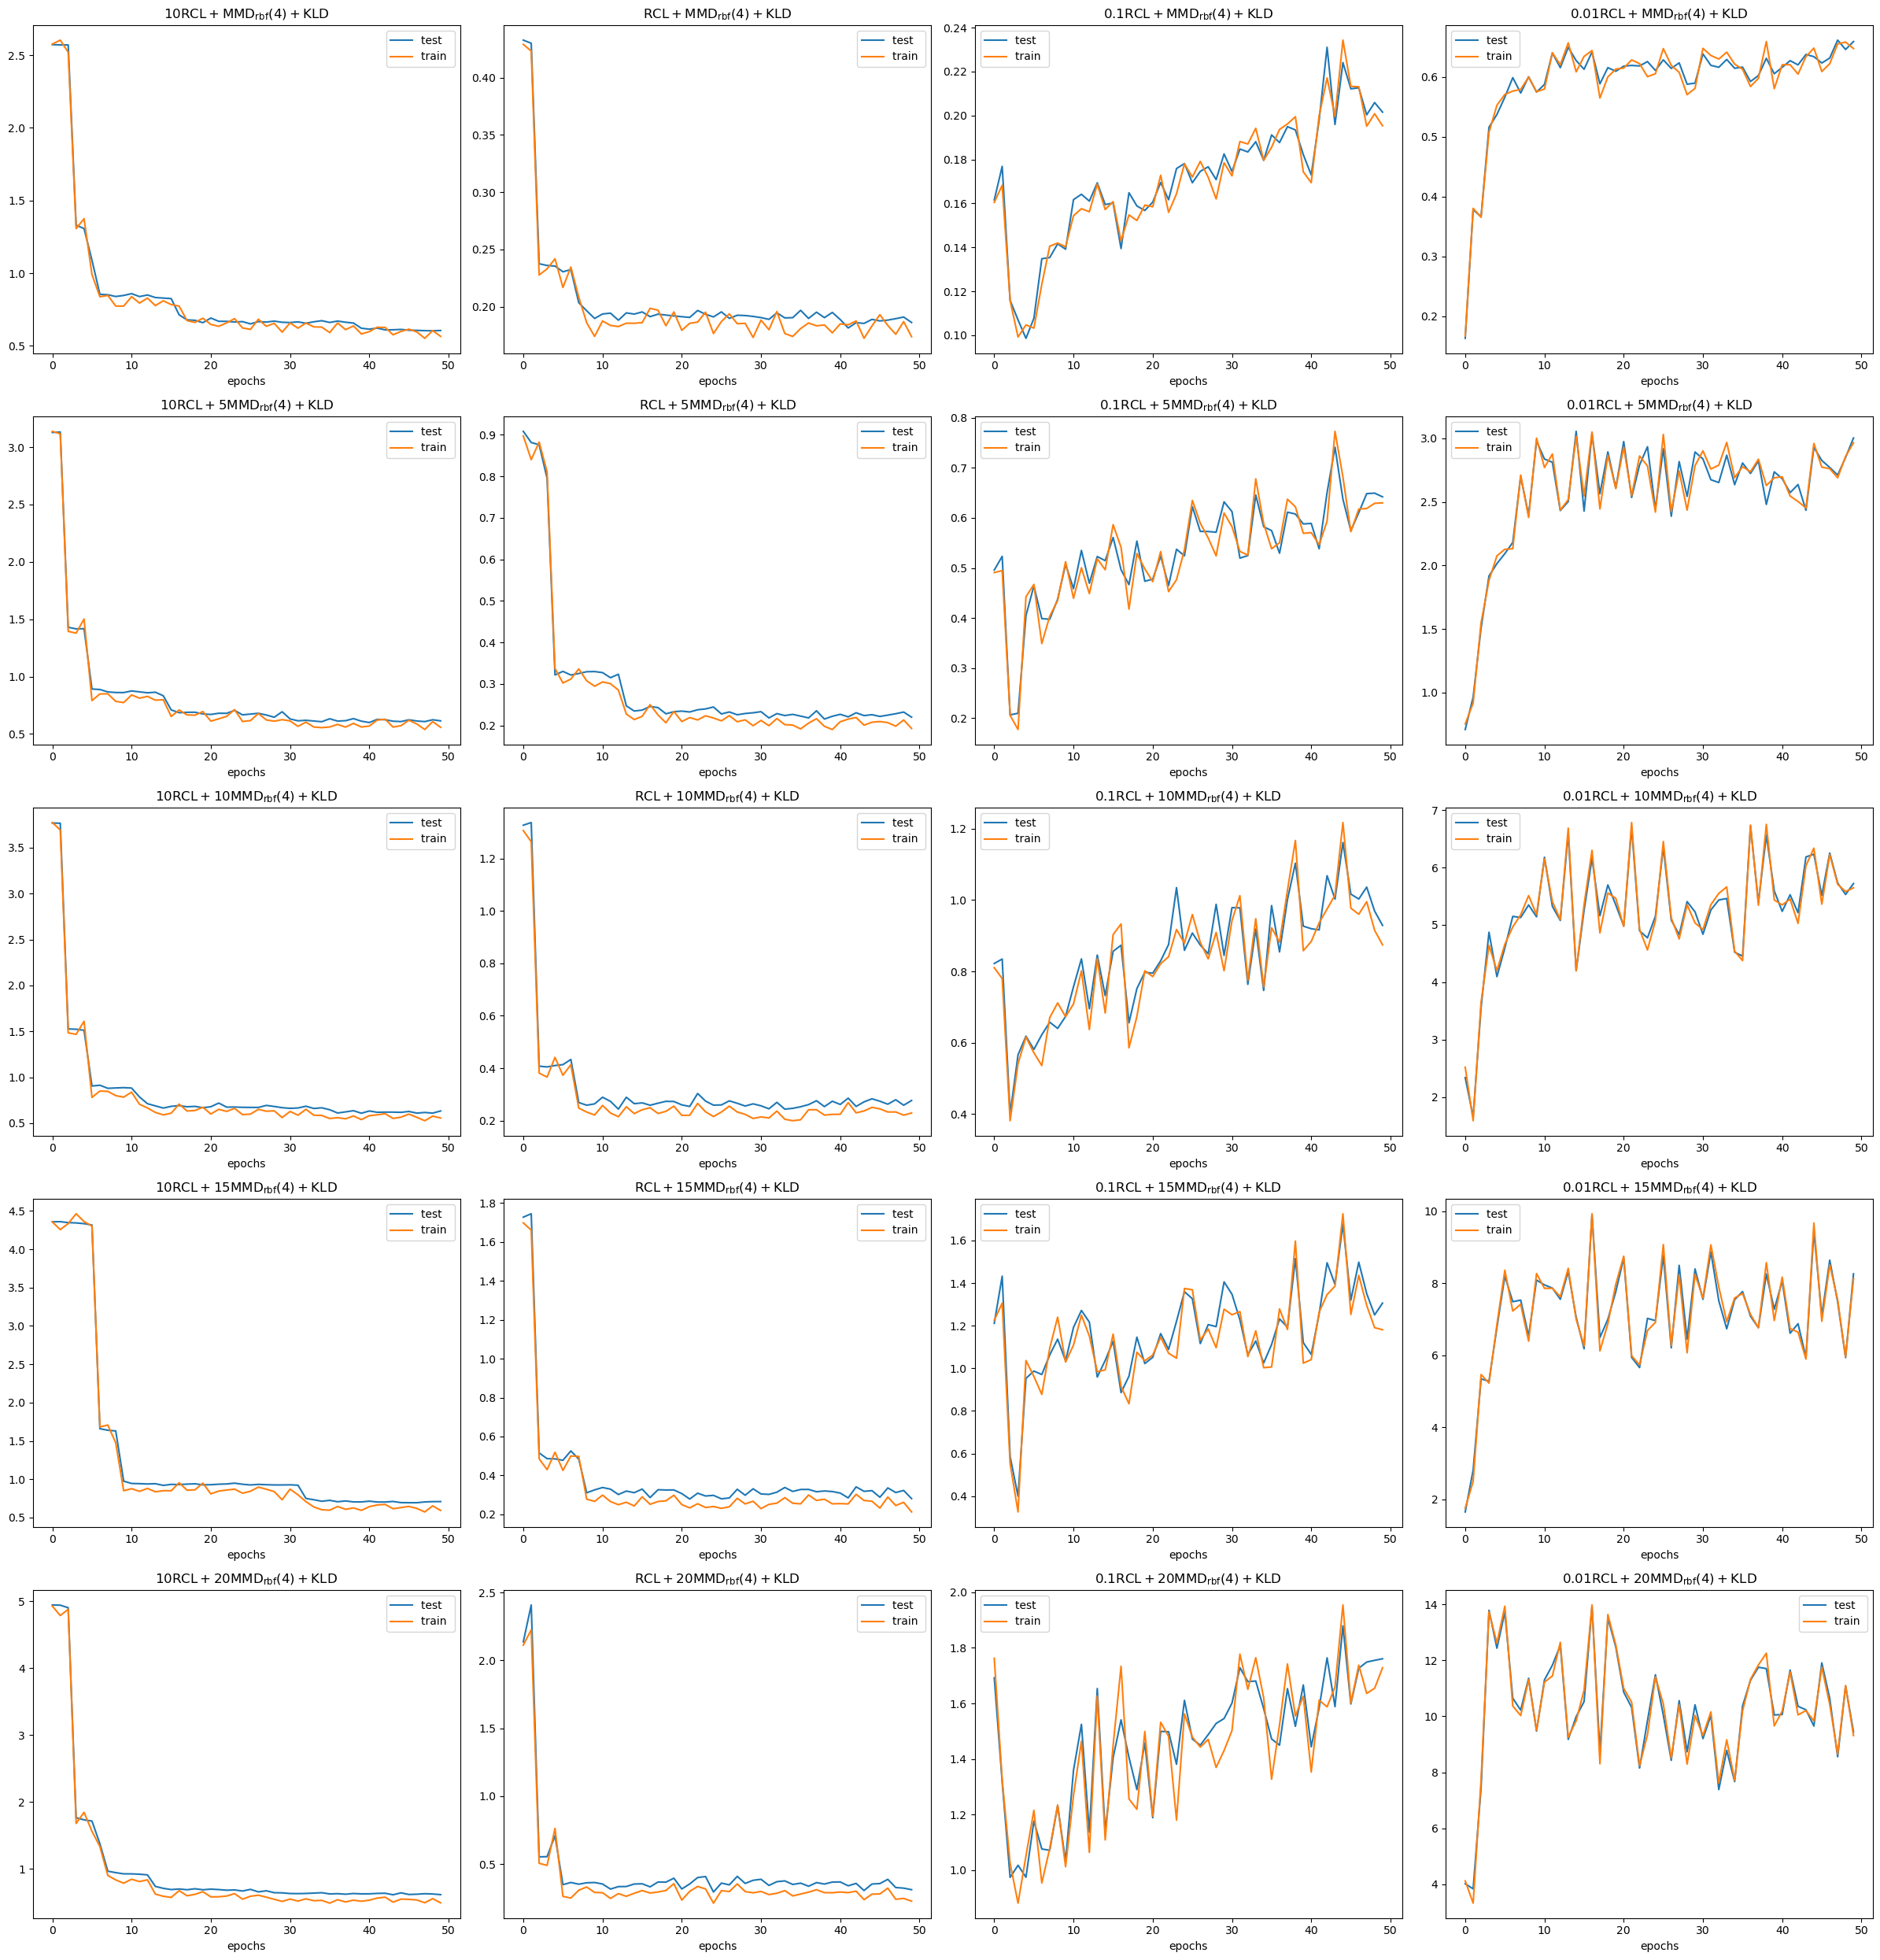

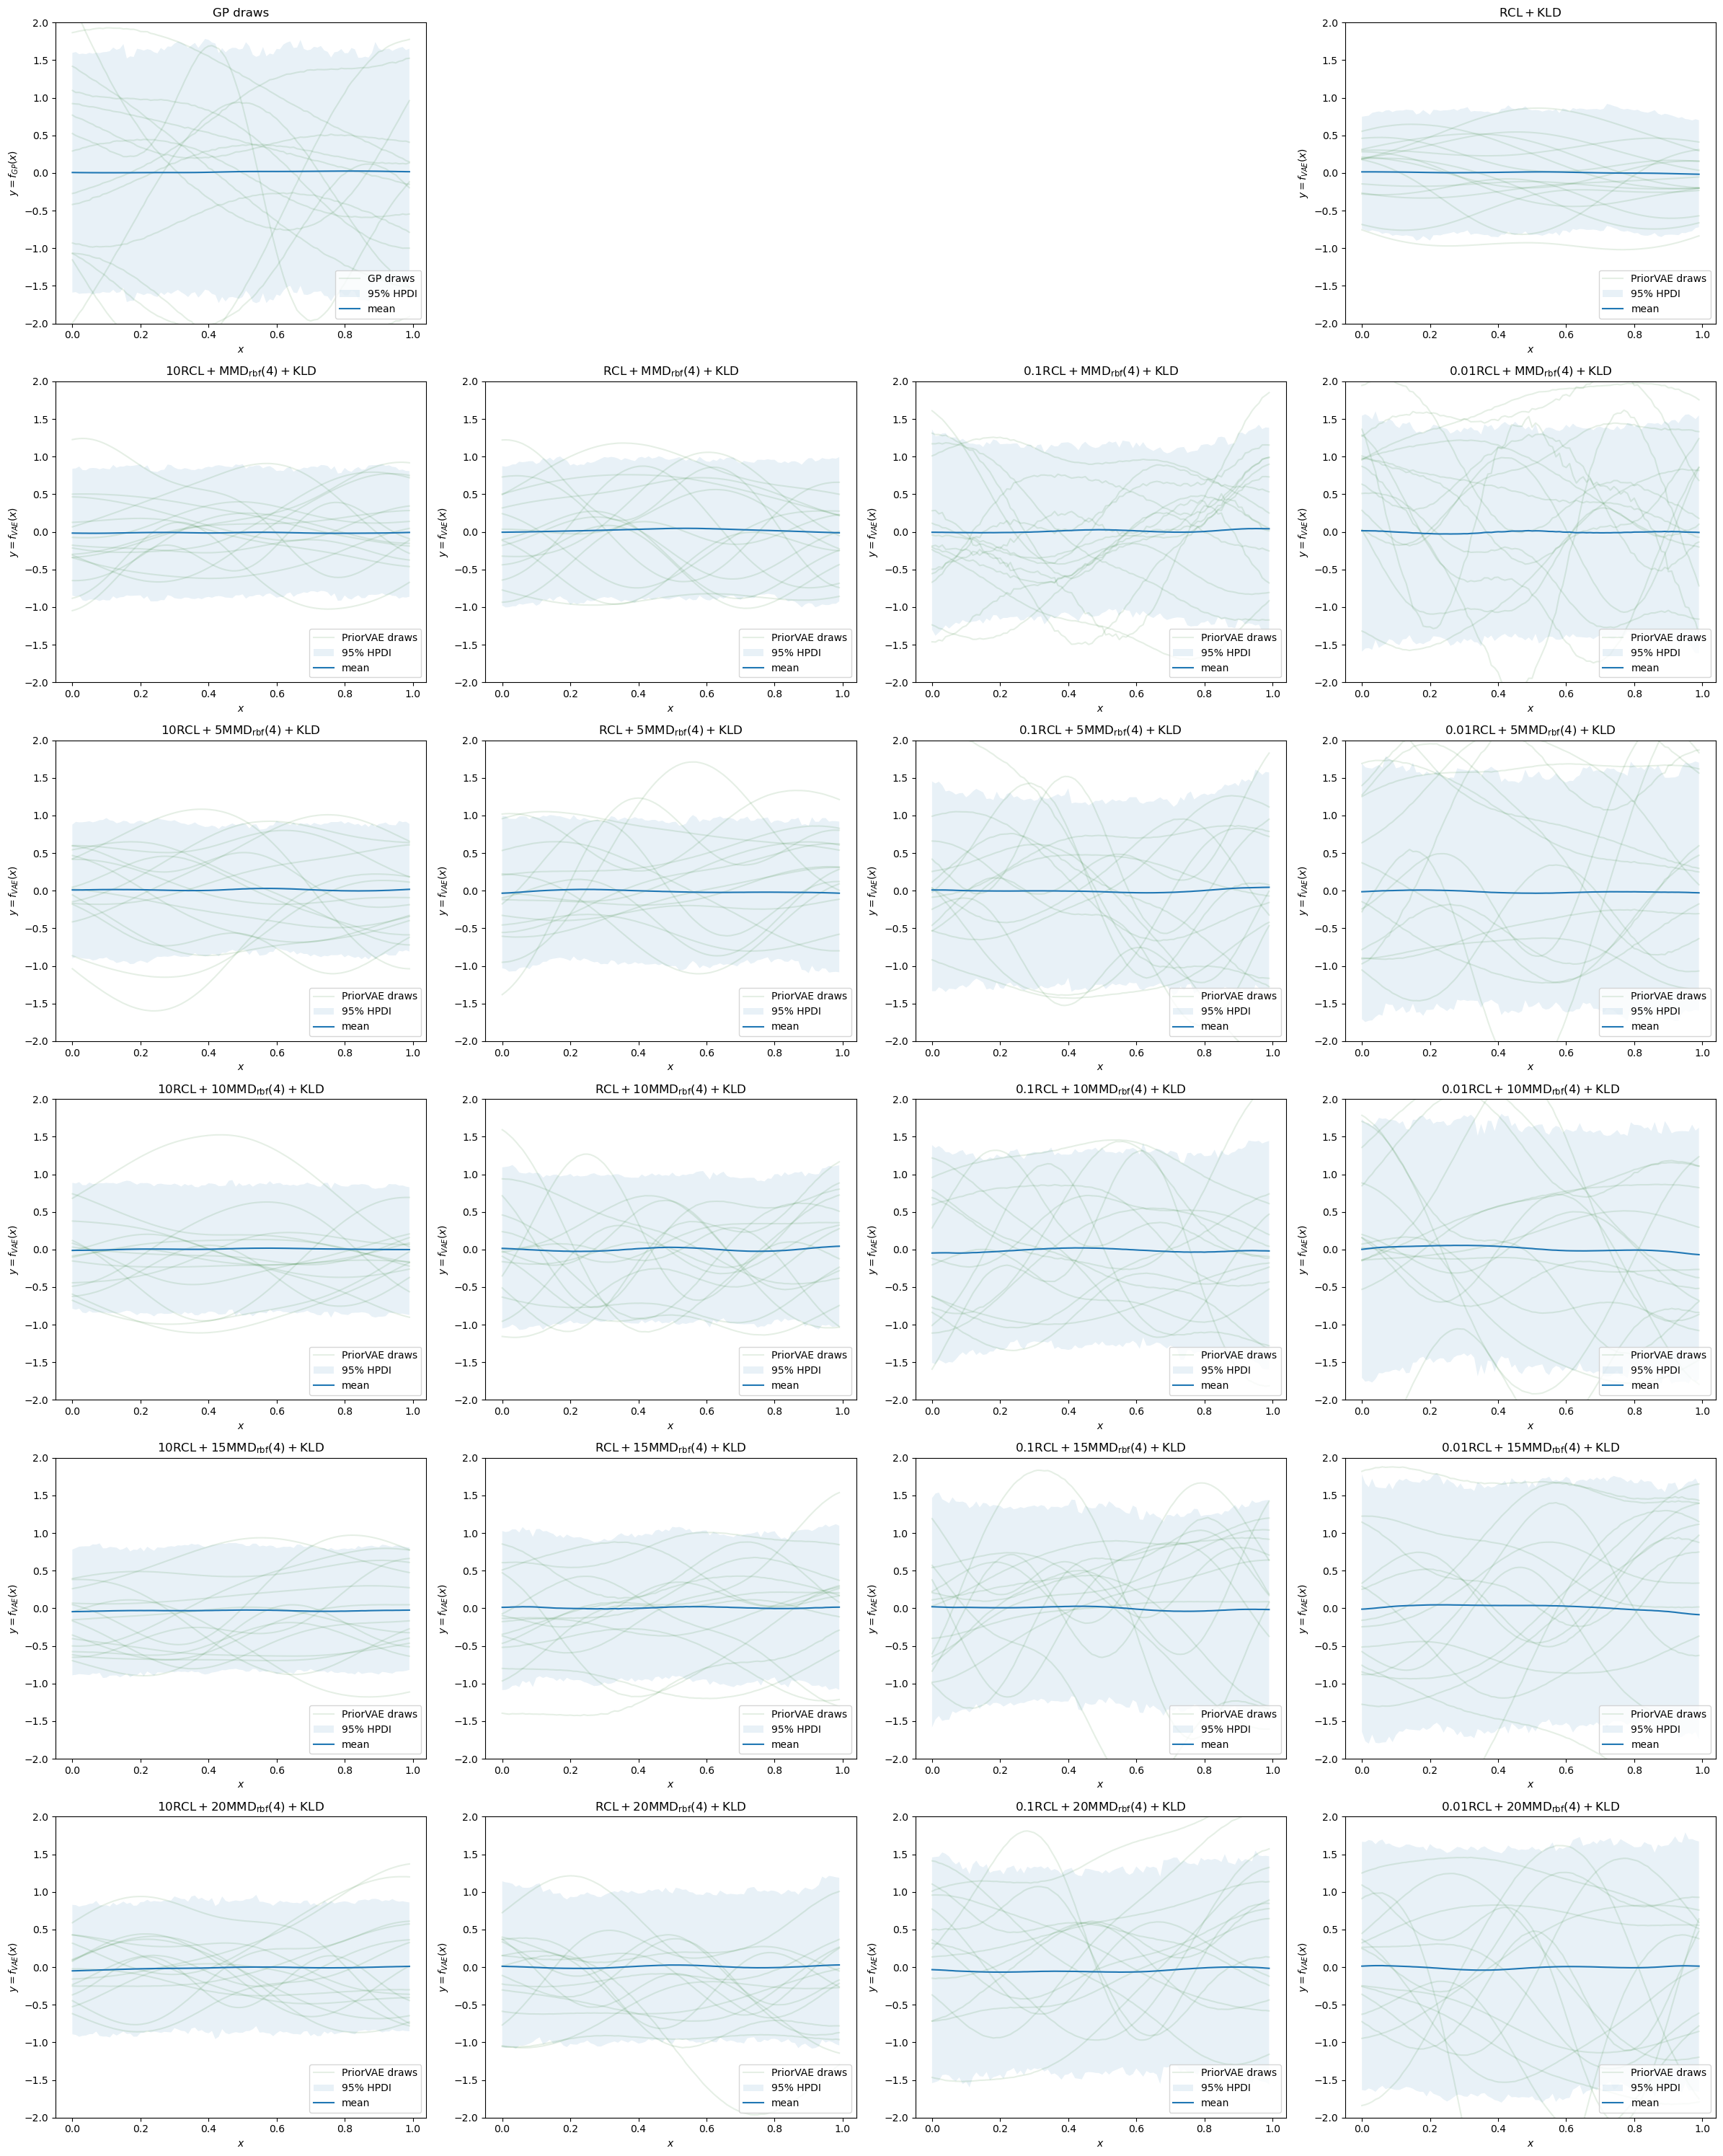

In [136]:
experiment = "exp3"
number = "1" # disambiguate argument files

show_loss_scores(16, experiment, number)
plot_training_histories(16, experiment, number, backfill="align_right")
plot_trained_draws(16, experiment, number,  backfill="align_right", include_standard_vae=True)

# 18 - leaky relu try

20 True 6 4


KeyError: 'VAE_Encoder_0'

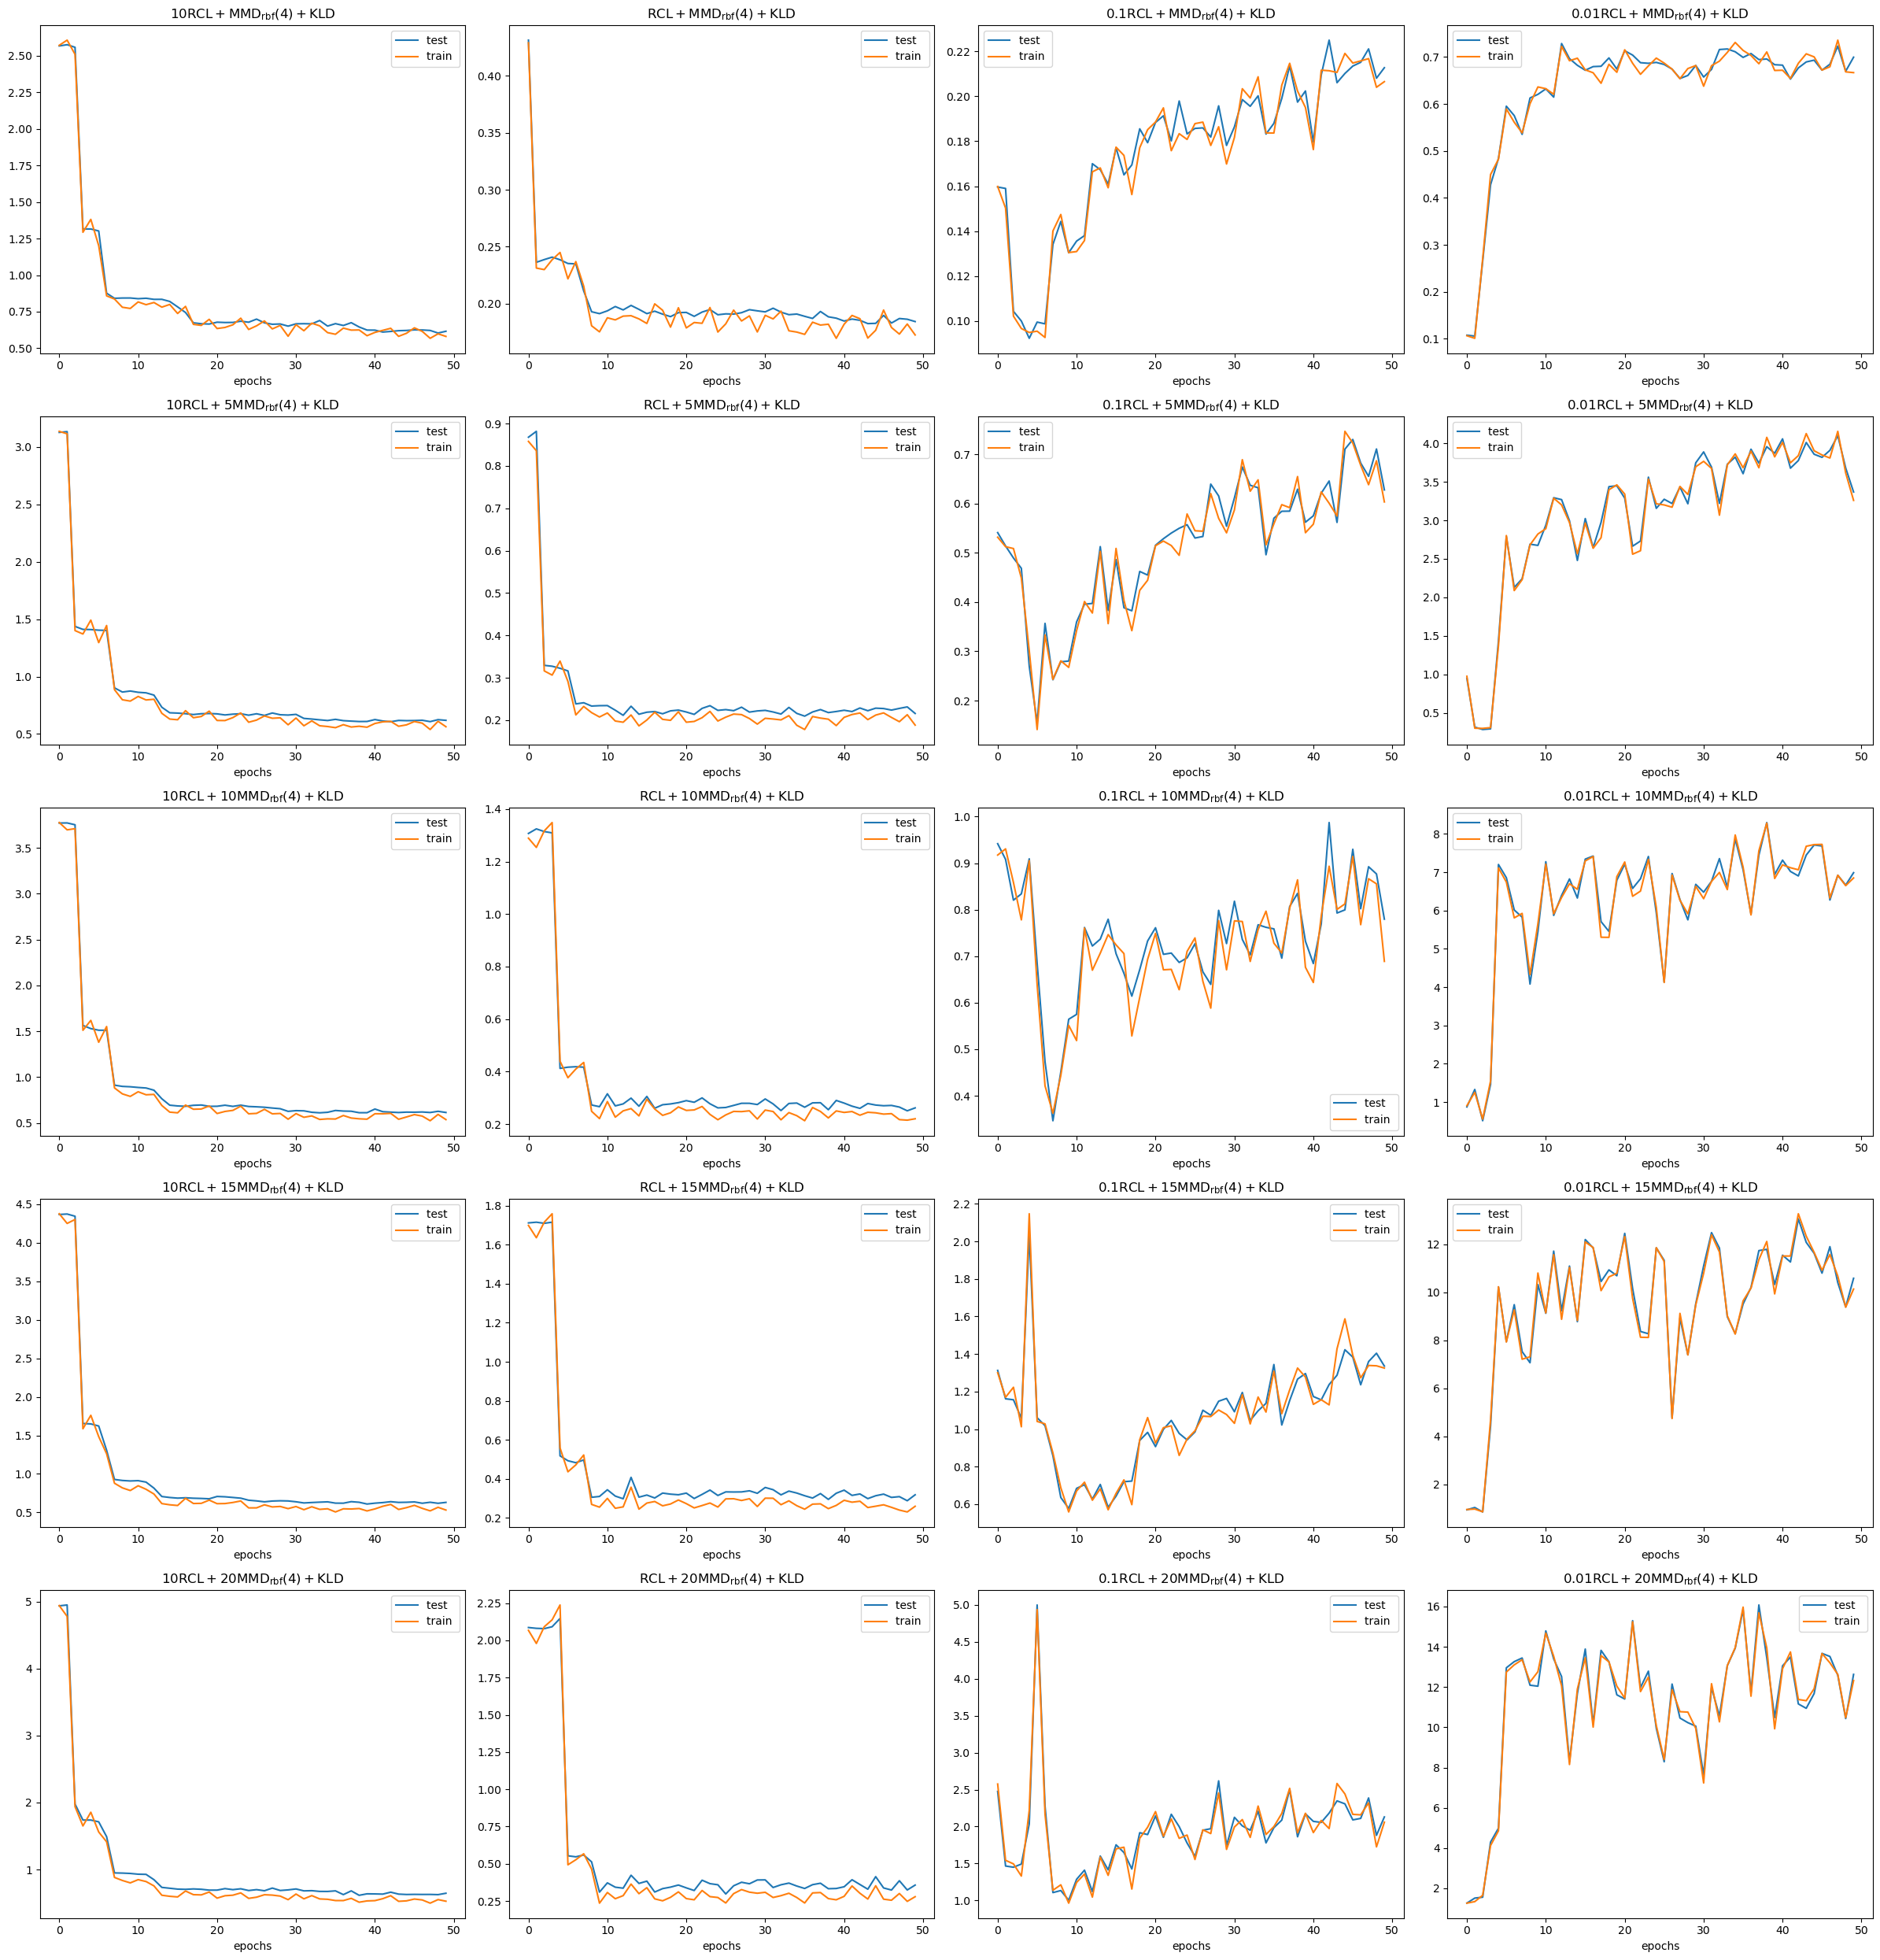

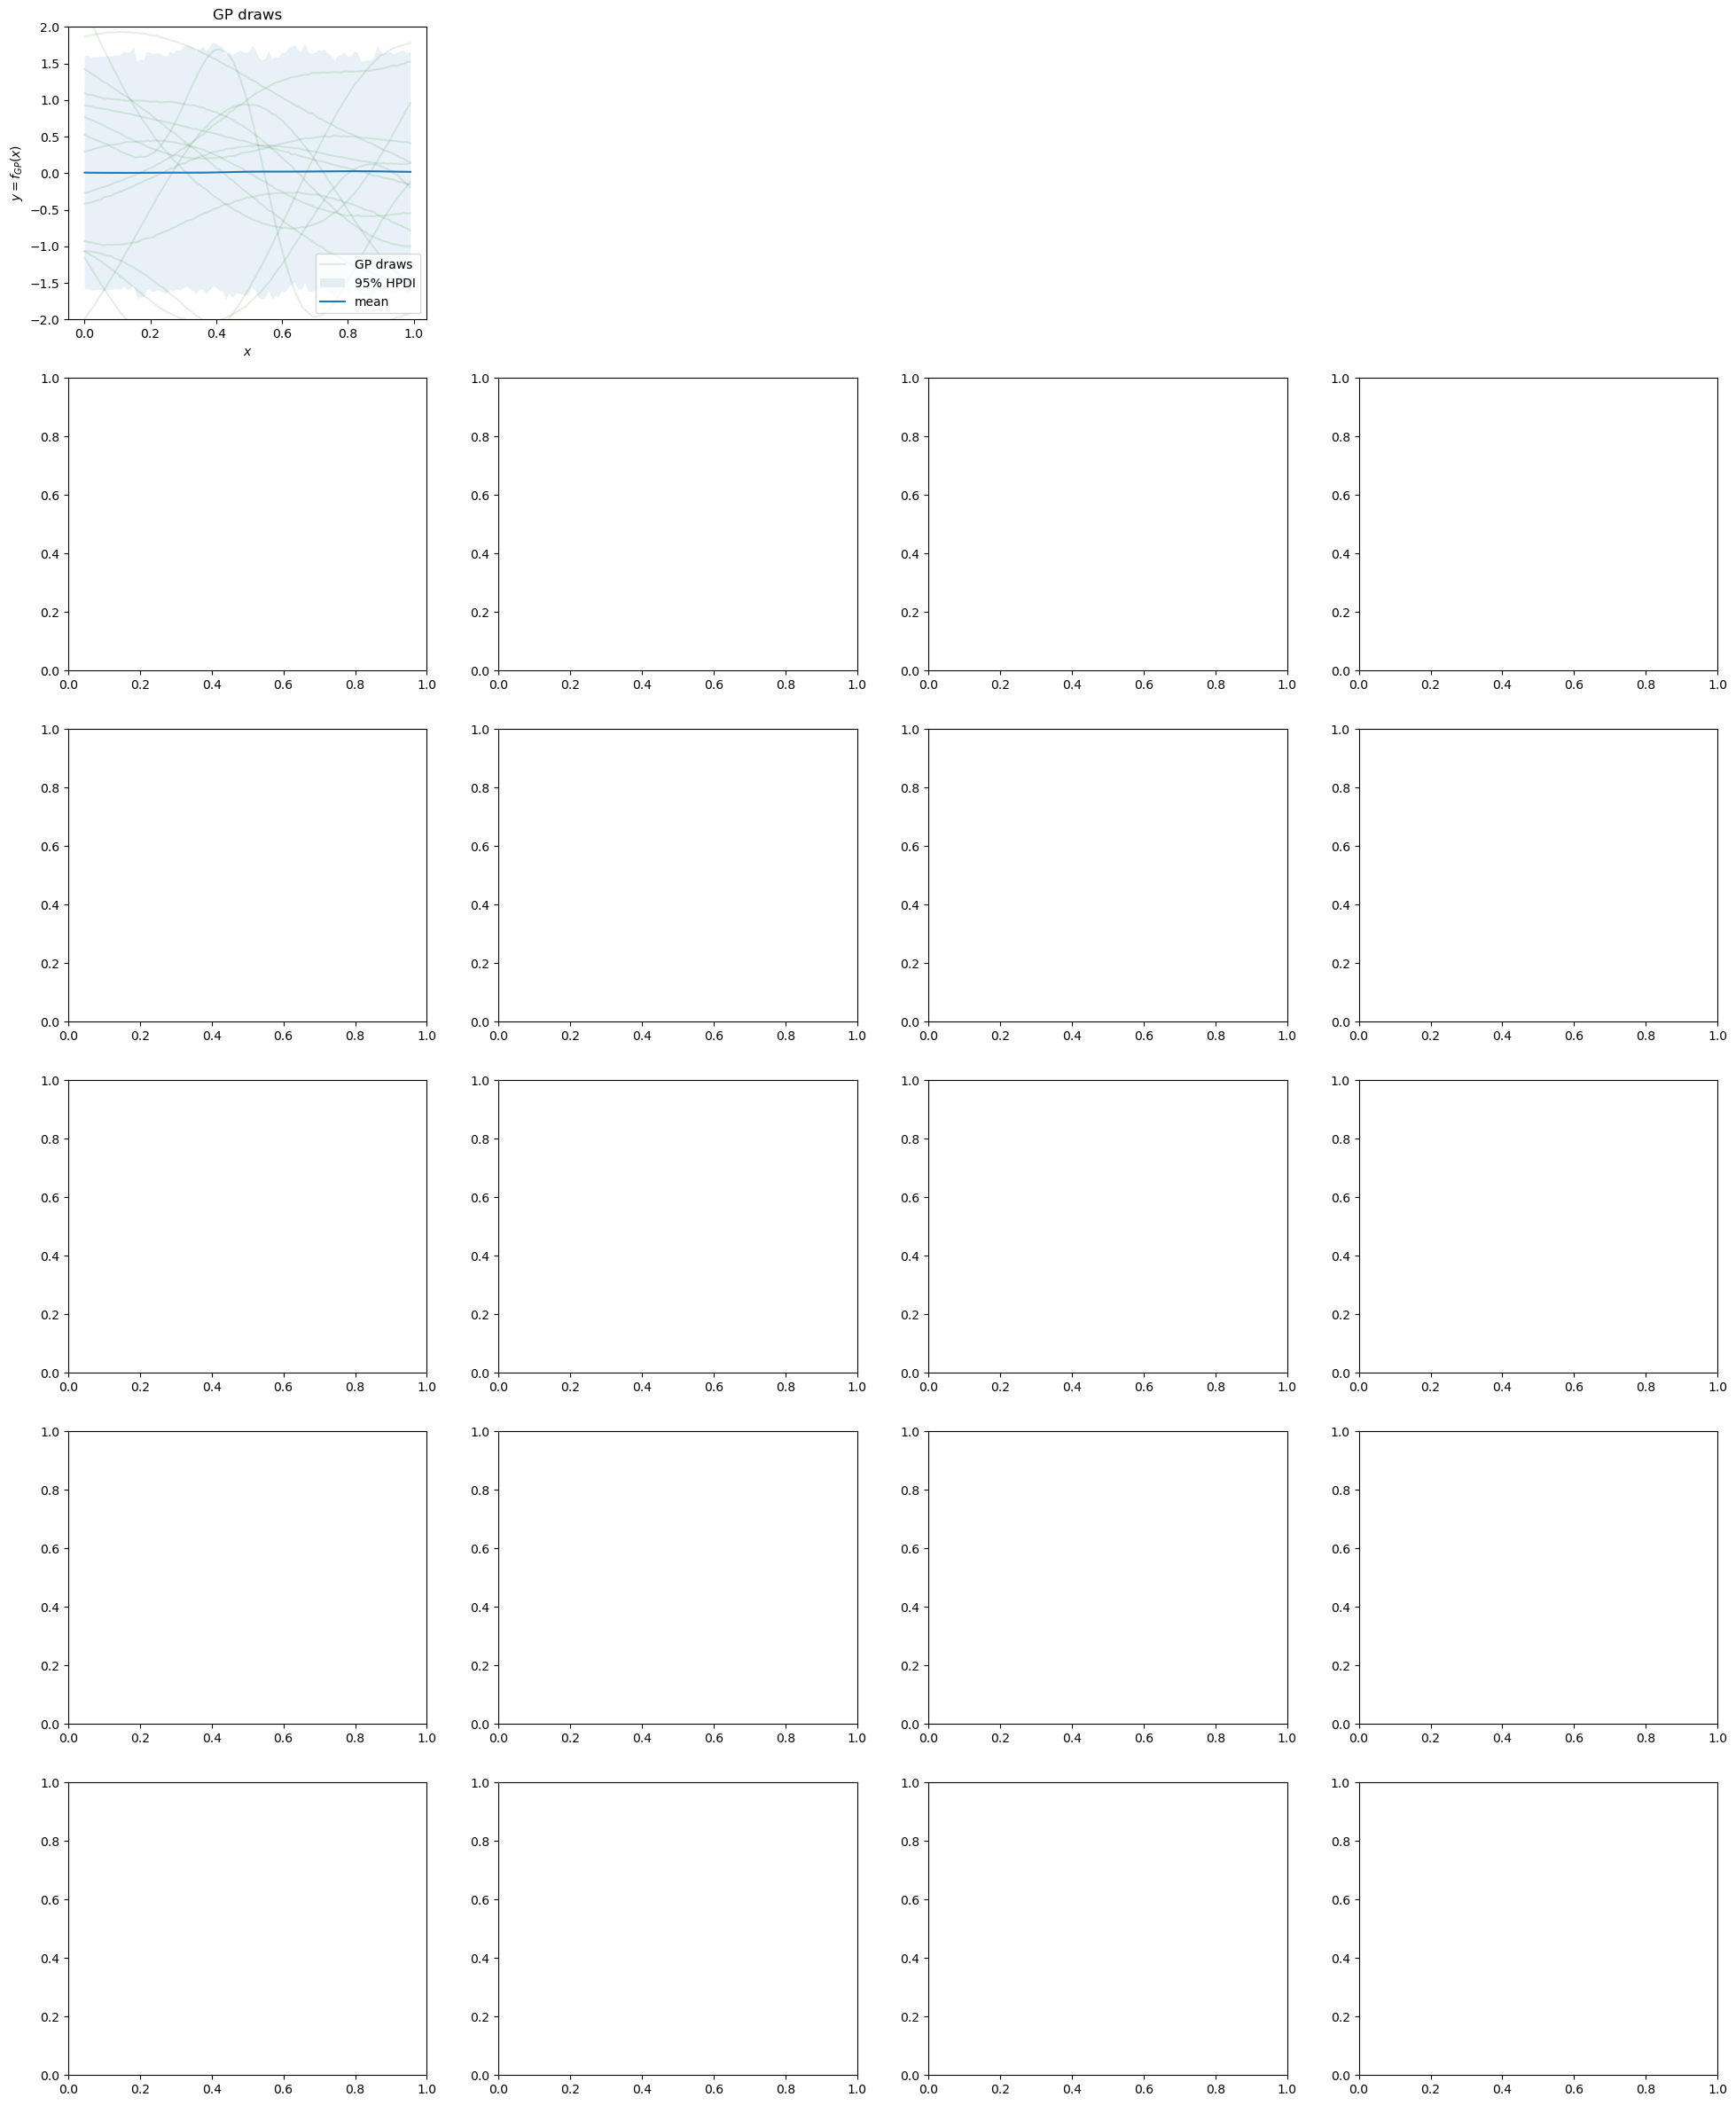

In [9]:
experiment = "exp3"
number = "1" # disambiguate argument files

#show_loss_scores(18, experiment, number)

plot_training_histories(18, experiment, number, backfill="align_right")
plot_trained_draws(18, experiment, number, backfill="align_right")

In [ ]:
code = 16
args_count = 1
exp_name = "exp3"


rng_key = random.PRNGKey(3)
rng_key, rng_key_gp = random.split(rng_key, 2)

args = load_args(str(code), str(args_count), exp_name)


i = 18
loss_fn = args["loss_fn_names"][i]

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot()


rng_key, rng_key_init, rng_key_predict = random.split(rng_key, 3)

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    conditional=False,
    leaky=False
)
params = module.init(rng_key, jnp.ones((args["n"],)))["params"]
tx = optax.adam(args["learning_rate"])
state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init)

decoder_params = get_decoder_params(
    load_training_state(code, gen_file_name(code, args, args["experiment"] + loss_fn), state)
    
)

plot_vae_predictive = Predictive(vae_sample, num_samples=5000)
vae_draws = plot_vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=decoder_params,
)["f"]

plot_draws_hpdi(
    vae_draws,
    args["x"],
    pretty_loss_fn_name(loss_fn),
    "$y=f_{VAE}(x)$",
    "PriorVAE",
    ax=ax,
)

print(decoder_params)

print(vae_draws)

fig.tight_layout()

fig.savefig(f"./gen_plots/{code}/{code}_{exp_name}_{args_count}_{i}_draws.png")


In [ ]:
new_state = load_training_state(code, gen_file_name(code, args, args["experiment"] + loss_fn), state)

from reusable.vae import VAE_Decoder

module2 = VAE_Decoder(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    out_dim=args["n"]
)
params = module2.init(rng_key, jnp.ones((args["latent_dim"],)))["params"]


batch = jnp.ones((args["latent_dim"],))

module2.apply(get_decoder_params(new_state), batch)